In [1]:
from __future__ import division
import tqdm
import os
import sys
sys.path.append('/mnt/disk0/home/jianwei_leejw/scripts/TESPulseFitCode')
# sys.path.append('/workspace/projects/TES/scripts')
import numpy as np
import matplotlib
# matplotlib.use('nbAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import glob
from lmfit import Model, Parameters
# import seaborn
import pickle

import pulse_utils as pu
import discriminator as disc
import discriminator_edges as disc_edges
import trace_param as trcp
import pulse_fit_powell as pfp
import pulse_fit_bulk_process as pfbulk
import heralded_pulses_analysis as hpa

In [2]:
results_directory = './'

In [3]:
# Loads Trace Parameters
[height_th, offset] = np.loadtxt(results_directory + 'disc_settings.dat')
offset = int(offset)
print height_th, offset

0.00966606909002 850


In [4]:
sigma0 = np.loadtxt(results_directory + 'rms.dat')
print sigma0

0.00187113676952


In [5]:
# Loads Pulse (fitting) Parameters
pulse_params =np.genfromtxt(results_directory + 'sum_and_diff_fit_params.dat',
                            delimiter="\t",
                            )
print pulse_params

[  1.40106954   1.94412778   2.39844108  57.01546348  -0.49868577
   0.49868577  57.01546348]


In [6]:
# Loads Two Photon Model
pkl_file = open(results_directory + 'two_pulse_fit_model.dat', 'rb')
two_pulse_fit = pickle.load(pkl_file)

In [7]:
# imports Two Photon filelist
tasks = np.genfromtxt(results_directory + 'filelist_two_photon.dat', delimiter=',',dtype='string')
print len(tasks)

7801


[[Model]]
    (Model(one_pulse, prefix='one_') + Model(one_pulse, prefix='two_'))
[[Variables]]
    one_x_offset:      3.1338e-07 (init= 3.275281e-07)
    two_x_offset:      1.2851e-06 (init= 1.269528e-06)
    sum_amplitudes:    1.69133702 (init= 1.963569)
    diff_amplitudes:   0.35905270 (init= 0)
    one_amplitude:     1.02519486  == '(sum_amplitudes + diff_amplitudes)/2'
    two_amplitude:     0.66614216  == '(sum_amplitudes - diff_amplitudes)/2'



(-0.0037422735390379904, 0.031325552230557045)

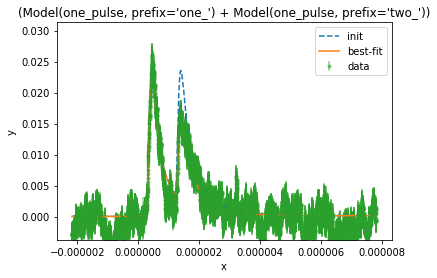

In [8]:
# tests fit for one interesting plot
reload(pfp)
fl = np.genfromtxt('filelist_two_photon.dat', delimiter='\n',dtype='string')
# print np.argwhere(tasks==tasks[2])
fname = fl[3]
time = pu.time_vector(fname)
signal = trcp.trace_extr(fname,height_th)
r = pfp.fit_two_cw(time,signal,
              two_pulse_fit,
              pulse_params,
              height_th,
              sigma0)
r.plot_fit(data_kws={'marker':'.','alpha':0.5})
print r.fit_report()
plt.ylim(-2*sigma0,np.max(signal)*1.2)

In [9]:
reload(trcp)
trcp.trace_extr(fname)

array([-0.00283937, -0.00301937, -0.00283937, ..., -0.00075137,
       -0.00067937, -0.00053537])

In [10]:
# lmfit (multiprocess) traces
cores = 23
reload(pfbulk)
reload(pfp)
pfbulk.run_fit_two_poolable(
    results_directory+\
    'results.csv',
    cores,
    tasks,
    two_pulse_fit, pulse_params, height_th, sigma0)